# Training Machine Learning Models

In [1]:
# import them
import pandas as pd
import matplotlib.pyplot as plt
import sklearn as sk
import seaborn as sns
from scipy import stats
from statsmodels.stats.diagnostic import lilliefors
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error



In [2]:
df = pd.read_csv('./results/df_preprocessed.csv')

## X / y

In [3]:
X = df.drop(columns=['grammes equivalent CO2/km'])
y = df['grammes equivalent CO2/km']

## Equilibrage des classes

## Echantillonage et choix des colonnes

On choisi la division train-dev-test. C'est une méthode couramment utilisée en apprentissage automatique pour évaluer la performance d'un modèle. Elle consiste à diviser les données en trois ensembles distincts : l'ensemble d'entraînement (train), l'ensemble de développement (dev) et l'ensemble de test (test). L'ensemble d'entraînement est utilisé pour entraîner le modèle, l'ensemble de développement pour ajuster les hyperparamètres et effectuer des validations intermédiaires, et l'ensemble de test pour évaluer la performance finale du modèle sur des données non vues et pouvoir le comparer avec d'autres modèles.

Une proportion courante de division est 70-15-15. Cela signifie que 70% des données sont utilisées pour l'entraînement, 15% pour le développement et 15% pour le test. Cette répartition permet d'avoir suffisamment de données pour entraîner le modèle tout en réservant une partie significative pour l'évaluation et l'ajustement des hyperparamètres, assurant ainsi une évaluation robuste de la performance du modèle.

In [4]:
def sample_to_train_test_split(X, y, test_size=0.3, random_state=42):
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=test_size, random_state=random_state, shuffle=True, stratify=None)
    X_dev, X_test, y_dev, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=random_state)
    return X_train, X_dev, X_test, y_train, y_dev, y_test

X_train, X_dev, X_test, y_train, y_dev, y_test = sample_to_train_test_split(X, y, test_size=0.3, random_state=42)


Puis on vérifie que nos échantillons sont bien répartie en réalisant un test anova. Si la p-valeur est supérieur au seuil on rejette l'hypothèse null: nos échantillons sont distribués différement.

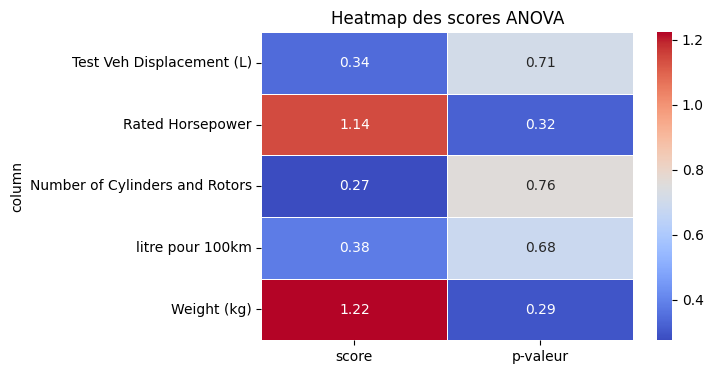

In [5]:
# TODO implémenter correctement ANOVA et faire une bonne étude de corrélation sur les variables catégorielles.
# TODO voir ce qu'il faut faire (en terme de choix d'échantillon avec des variable catégorielles)

df_anova_score = pd.DataFrame({"column": [], "score": [], "p-valeur": []})


# Fonction pour effectuer l'ANOVA et visualiser les résultats
def analyze_correlation(col_name, X_train, X_dev, X_test):
    # Effectuer l'ANOVA
    anova_result = stats.f_oneway(
        list(X_train[col_name]), 
        list(X_dev[col_name]), 
        list(X_test[col_name])
    )

    return anova_result.statistic, anova_result.pvalue

# Analyser chaque combinaison de colonnes catégorielles et numériques
# non numerical columns
for col_name in X.columns:
    score, pvalue = analyze_correlation(col_name, X_train, X_dev, X_test)
    df_anova_score.loc[len(df_anova_score)] = [col_name, score, pvalue]

# Création de la heatmap avec seaborn
plt.figure(figsize=(6, 4))  # Ajuster la taille
sns.heatmap(df_anova_score.set_index("column"), annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)

# Affichage du graphique
plt.title("Heatmap des scores ANOVA")
plt.show()


Ici on observe que H0: "les groupes ont la même population", est validé pour un alpha=0.08. Donc avec confiance on continue la démarche.
Le score anova à droite (F-score) est donné par: (variance global)/(moyenne des variances de chaque groupe)

#### En validation croisée

La validation croisée est une technique plus robuste qui divise les données en plusieurs sous-ensembles (ou "folds"). Le modèle est entraîné et validé sur différentes combinaisons de ces folds. Le détail des scores avec la validation croisée seront vus plus tard (car ils demandent d'avoir déjà les modèles)


### Choix des colonnes

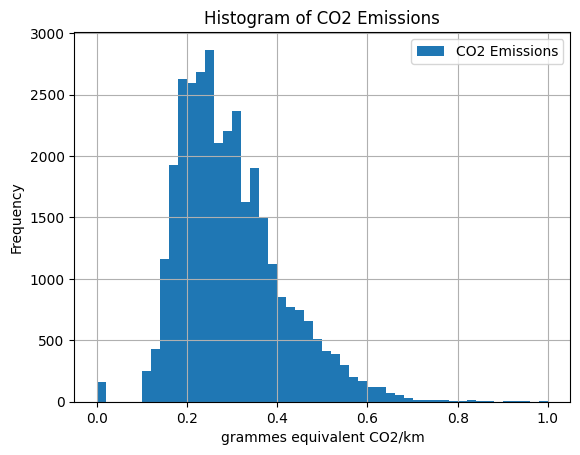

In [6]:
df["grammes equivalent CO2/km"].hist(bins=50, label="CO2 Emissions")  # Increase bins for thinner bars
plt.legend()  # Add legend
plt.xlabel("grammes equivalent CO2/km")  # Optional: Label for x-axis
plt.ylabel("Frequency")  # Optional: Label for y-axis
plt.title("Histogram of CO2 Emissions")  # Optional: Add a title
plt.show()  # Display the plot

## Model choosing

In [ ]:
from sklearn.svm import SVR
import xgboost as xgb
import lightgbm as lgb
from sklearn.ensemble import RandomForestRegressor
import scipy.sparse
from catboost import CatBoostRegressor


In [9]:
models_results = {}

### Choix des métriques
MSE
RSME
MSE
MAE
R2

### Random Forest

In [10]:
X_train, X_dev, X_test, y_train, y_dev, y_test = sample_to_train_test_split(X, y, test_size=0.3, random_state=42)

# apprentissage sur les données standardisées
rf = RandomForestRegressor(random_state=42)
rf.fit(X_train, y_train)

# prédiction et test
y_pred = rf.predict(X_dev)
rf_mse = mean_squared_error(y_dev, y_pred)
print(f"Mean Squared Error (MSE) sur test set : {rf_mse:.2f}")
models_results["Random Forest"] = rf_mse


Mean Squared Error (MSE) sur test set : 0.00


### CAT Boost

In [11]:
# Initialize CatBoost Regressor
model = CatBoostRegressor(iterations=1000, learning_rate=0.1, depth=6)

# Train the model
model.fit(X_train, y_train, eval_set=(X_test, y_test), verbose=200)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Calculate MSE
cat_mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {cat_mse}")
models_results["Cat Boost"] = cat_mse


0:	learn: 0.1038341	test: 0.1020937	best: 0.1020937 (0)	total: 90.5ms	remaining: 1m 30s
200:	learn: 0.0236090	test: 0.0217854	best: 0.0217854 (200)	total: 666ms	remaining: 2.65s
400:	learn: 0.0213519	test: 0.0205998	best: 0.0205998 (400)	total: 1.29s	remaining: 1.93s
600:	learn: 0.0200817	test: 0.0202217	best: 0.0202210 (598)	total: 1.95s	remaining: 1.29s
800:	learn: 0.0190951	test: 0.0198988	best: 0.0198988 (800)	total: 2.56s	remaining: 635ms
999:	learn: 0.0184175	test: 0.0196163	best: 0.0196116 (994)	total: 3.15s	remaining: 0us

bestTest = 0.01961156791
bestIteration = 994

Shrink model to first 995 iterations.
Mean Squared Error: 0.00038461359664172974


### LGB

In [12]:
# Initialize LightGBM Regressor
lgb_model = lgb.LGBMRegressor(n_estimators=100, learning_rate=0.1, max_depth=6)

# Train the model
lgb_model.fit(X_train, y_train)

# Predict
y_pred_lgb = lgb_model.predict(X_test)

# Compute MSE
mse_lgb = mean_squared_error(y_test, y_pred_lgb)
print(f"LightGBM MSE: {mse_lgb}")
models_results["LightGBM"] = mse_lgb

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000228 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 609
[LightGBM] [Info] Number of data points in the train set: 23121, number of used features: 5
[LightGBM] [Info] Start training from score 0.297241
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

### SVR

In [13]:
# Initialize SVR model
svr_model = SVR(kernel='rbf', C=100, gamma='scale')

# Train the model
svr_model.fit(X_train, y_train)

# Predict
y_pred_svr = svr_model.predict(X_test)

# Compute MSE
mse_svr = mean_squared_error(y_test, y_pred_svr)
print(f"SVR MSE: {mse_svr}")
models_results["SVR"] = mse_svr

SVR MSE: 0.00450491015603478


### XGB

In [14]:
# Initialize XGBoost Regressor
xgb_model = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=6)

# Train the model
xgb_model.fit(X_train, y_train)

# Predict
y_pred_xgb = xgb_model.predict(X_test)

# Compute MSE
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
print(f"XGBoost MSE: {mse_xgb}")
models_results["XGBoost"] = mse_xgb

XGBoost MSE: 0.00042973613854475234


## Comparaisons sur les échantillons de test

In [15]:
del models_results["Random Forest"]

In [19]:
models_results

{'Cat Boost': 0.00038461359664172974,
 'LightGBM': 0.00046648335259171707,
 'SVR': 0.00450491015603478,
 'XGBoost': 0.00042973613854475234}

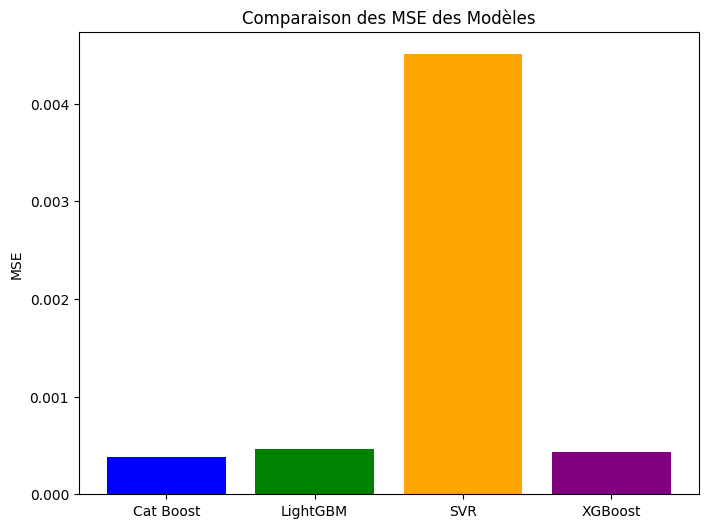

In [21]:
plt.figure(figsize=(8, 6))
plt.bar(models_results.keys(), models_results.values(), color=['blue', 'green', 'orange', 'purple'])
plt.title('Comparaison des MSE des Modèles')
plt.ylabel('MSE')
plt.show()

## Conclusion